In [1]:
from pathlib import Path

import cmocean
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize, SymLogNorm
from scipy import integrate as si

plt.style.use("../paper.mplstyle")


In [2]:
# Perpendicular
def get_dataarray(
    df: pd.DataFrame, nfreq: int = 10001, method: str = "nearest", tol=1e-5, name=None
) -> xr.DataArray:
    """Extract DataArray from Nimrod's Excel sheet"""
    _x = np.array(df.iloc[3:, 2], dtype=float)
    _y = np.array(df.iloc[0, 4:41], dtype=float)
    _data = df.iloc[3:, 4:41]

    # data on experimental frequency grid
    da = xr.DataArray(_data.T, coords={"angle": _y, "frequency": _x}).dropna(
        dim="frequency"
    )

    # intepolate to regular grid
    _xmin = float(da.frequency.min())
    _xmax = float(da.frequency.max())
    _x = np.linspace(_xmin, _xmax, nfreq)
    da = da.interp(frequency=_x, method=method)

    da.data[da.data <= tol] = tol
    da.name = name

    return da

In [3]:
file = "data_exp_GaN_488nm_1010.xlsx"
df_para = pd.read_excel(file, sheet_name="Para_10-10")
df_crss = pd.read_excel(file, sheet_name="Crss_10-10")
da_para = get_dataarray(df_para, name="parallel")
da_crss = get_dataarray(df_crss, name="perpendicular")
ds_po = xr.merge([da_para, da_crss])
ds_po.to_netcdf("outfile.intensity_raman_po_1010.h5")
df_100 = ds_po.sum(dim="angle").to_dataframe()
df_100.to_csv("intensity_exp_polarized_1010.csv", index="frequency")

ds_theory = xr.load_dataset("outfile.raman_intensity_100_po.h5")


In [4]:
def normalize(x, y, xmin=100, factor=0.95):
    mask = x > xmin
    _x = x[mask]
    _y = y[mask]
    y_int = si.trapezoid(_y - _y.min(), _x)
    y_out = y / y_int
    return y_out / y_out.max() * factor

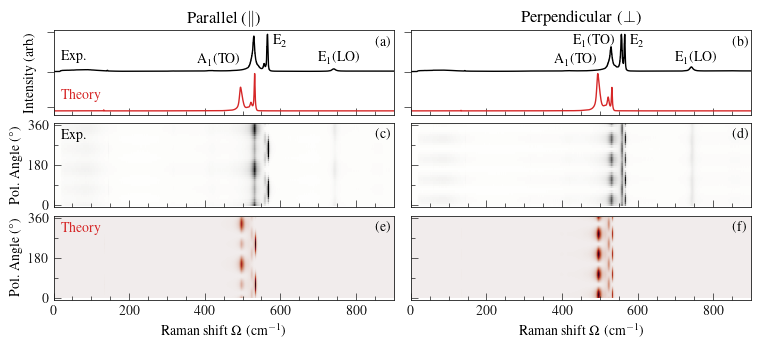

In [5]:
# with unpolarized spectra


ds0 = ds_po
ds1 = ds_theory

fig, axs = plt.subplots(ncols=2, nrows=3, sharey="row", figsize=(9, 3.5), sharex="col")
fig.subplots_adjust(wspace=0.05, hspace=0.1)

xlim = (0, 900)

# exp
_ds = ds0
for ax, var in zip(axs[1, :], _ds.data_vars):
    da = _ds[var]
    da = da - da.min()
    da = da / da.sum()
    vmin = da.data.min()
    vmax = da.data.max()
    kw = {"vmin": 5e-3 * vmax, "vmax": 1 * vmax, "clip": True}
    norm = LogNorm(**kw)
    norm = Normalize(vmin=0, vmax=vmax)
    # norm = SymLogNorm(1e-5, vmin=0, vmax=vmax)
    xr.plot.imshow(
        da,
        ax=ax,
        norm=norm,
        add_colorbar=False,
        add_labels=False,
        cmap=cmocean.cm.gray_r,
    )


# unpolarized
for ax, var in zip(axs[0], _ds.data_vars):
    _da = _ds[var].sum(dim="angle")
    _x = _da.frequency
    _y = normalize(_x, _da)
    ax.plot(_x, _y + 1, label=var, color="k", lw=1)


# theory
_ds = ds1
for ax, var in zip(axs[2], _ds.data_vars):
    da = _ds[var]
    # da['frequency']  = 1.065 * da['frequency']
    da = da - da.min()
    da = da / da.sum()
    vmin = da.data.min()
    vmax = da.data.max()
    # normalize integral to 1
    kw = {"vmin": 1e-5 * vmax, "vmax": 1 * vmax, "clip": False}
    norm = LogNorm(**kw)
    norm = Normalize(vmin=0, vmax=vmax)

    da = da.roll(angle=60)

    xr.plot.imshow(
        da, ax=ax, norm=norm, add_colorbar=False, add_labels=False, cmap=cmocean.cm.amp
    )
    ax.set_xlim(xlim)

# unpolarized
for ax, var in zip(axs[0], _ds.data_vars):
    _da = _ds[var].sum(dim="angle")
    _x = _da.frequency
    _y = normalize(_x, _da)
    ax.plot(_x, _y, label=var, color="C3", lw=1)
    # ax.plot(_x, _y_total)

# labels
for ax in axs[1:, 0]:
    ax.set_ylabel("Pol. Angle (°)")

for ax in axs[2, :]:
    ax.set_xlabel(r"Raman shift $\Omega$ (cm$^{-1}$)")

ax = axs[0, 0]
ax.set_title(r"Parallel ($\parallel$)")

ax = axs[0, 1]
ax.set_title(r"Perpendicular ($\perp$)")

for ax in axs[1:, :].flatten():

    ax.set_ylim(-10, 370)
    xticks = np.arange(*xlim, 100)
    xticks_minor = np.arange(*xlim, 50)
    ax.set_xticks(xticks_minor, minor=True)

    yticks = np.arange(0, 361, 180)
    ax.set_yticks(yticks, minor=False)

    yticks_minor = np.arange(0, 360, 90)
    ax.set_yticks(yticks_minor, minor=True)

    ax.tick_params(axis="both", direction="in", which="both")

for ax in axs[0].flatten():

    # ax.set_yticks(yticks, minor=False)

    # yticks_minor = np.arange(0, 360, 45)
    # ax.set_yticks(yticks_minor, minor=True)
    ax.set_yticks([0.1, 1, 2])
    ax.set_yticklabels([])

    ax.tick_params(axis="y", direction="out", which="both")

# label
ax = axs[0, 0]
ax.text(20, 1.3, "Exp.", color="k")
ax.text(20, 0.3, "Theory", color="C3")
ax = axs[1, 0]
ax.text(20, 340, "Exp.", va="top", color="k")
ax = axs[2, 0]
ax.text(20, 340, "Theory", va="top", color="C3")

axs[0, 0].set_ylabel("Intensity (arb.)")

# put mode labels
ax = axs[0, 0]
ax.text(380, 1.2, r"A$_1$(TO)")
ax.text(580, 1.7, r"E$_2$")
ax.text(700, 1.25, r"E$_1$(LO)")
ax = axs[0, 1]
ax.text(580, 1.7, "E$_2$")
ax.text(700, 1.25, "E$_1$(LO)")
ax.text(380, 1.2, "A$_1$(TO)")
ax.text(430, 1.7, "E$_1$(TO)")

labels = [f"({x})" for x in "a b c d e f".split()]
for _ax, _l in zip(axs.flatten(), labels):
    _ax.text(850, 0.82 * _ax.get_ylim()[1], _l)


file = "plot_GaN_488nm_PO_101_total_linear.pdf"
fig.savefig(file)
fig.savefig(Path(file).stem + ".png")